In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-05-06 16:10:37.320007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-06 16:10:38.633347: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-06 16:10:38.635799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-06 16:10:38.701274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 16:10:38.701363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-06 16:10:38.701378: I tensorflow/stream_executor/platform/def

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.deep_learning.neural_networks.create_conv_model import create_conv_model
from src.deep_learning.soundtype_classifier.classifier_datasets import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Choose dataset
path_to_datasets = PATH_TO_PROJECT + 'models/classifier/datasets/'
path_to_models = PATH_TO_PROJECT + 'models/classifier/networks/'
all_datasets = os.listdir(path_to_datasets)
dataset_name = all_datasets[5]
print(dataset_name)

berlin_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000


In [11]:
# Load data
(sounds_metadata_train, sounds_npy_train, melspecs_train, sounds_metadata_test,
 sounds_npy_test, melspecs_test, all_classes_str) = load_dataset(path_to_datasets, dataset_name)

In [12]:
sounds_metadata_train['cl'].value_counts()

softchirp      14095
downsweep       8145
pupcombo        6660
whistle         6480
combotwo        6300
combo           5880
scream          5580
pupcheveron     5490
loudchirp       5310
grunt           5050
upsweep         5040
pupsquawk       4620
hiccup          3400
Name: cl, dtype: int64

In [13]:
sounds_metadata_test['cl'].value_counts()

softchirp      1177
pupcombo        248
downsweep       202
whistle          99
combotwo         65
combo            59
grunt            56
pupcheveron      56
scream           46
pupsquawk        35
upsweep          27
loudchirp        18
hiccup            3
Name: cl, dtype: int64

In [81]:
# Print some info about the datset
print('All classes:\n', all_classes_str)
print('\n      Training sounds:')
print(sounds_metadata_train['cl'].value_counts())
print('\n      Test sounds:')
print(sounds_metadata_test['cl'].value_counts())

All classes:
 ['phee', 'scream', 'sq', 'sul', 'tweet']

      Training sounds:
scream    4225
sq        2295
sul       1680
phee      1595
tweet     1575
Name: cl, dtype: int64

      Test sounds:
sq        217
scream    192
sul        43
phee        8
tweet       7
Name: cl, dtype: int64


In [82]:
# Transform labels into numerical format, get spec shape, transform data to 4 dimensions.
y_train_str = sounds_metadata_train['cl']
y_test_str = sounds_metadata_test['cl']
y_train = y_train_str.apply(lambda x: all_classes_str.index(x))
y_test = y_test_str.apply(lambda x: all_classes_str.index(x))
if len(melspecs_train.shape) < 4:
    melspecs_train = melspecs_train.reshape((*melspecs_train.shape, 1))
if len(melspecs_test.shape) < 4:
    melspecs_test = melspecs_test.reshape((*melspecs_test.shape, 1))
img_shape = melspecs_train.shape[1:3]
print('Image shape:', img_shape)

Image shape: (80, 64)


In [83]:
model = create_conv_model(img_shape, all_classes_str)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 80, 64, 64)        640       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 40, 32, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 40, 32, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 40, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 20, 16, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 20, 16, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 20, 16, 64)       

In [84]:
epochs = 30
model.fit(melspecs_train, y_train, epochs=epochs, batch_size=256, validation_data=(melspecs_test, y_test))
model.save(path_to_models + dataset_name)

Epoch 1/30
45/45 [==============================] - 2s 38ms/step - loss: 1.7065 - sparse_categorical_accuracy: 0.3505 - val_loss: 1.1628 - val_sparse_categorical_accuracy: 0.5246
Epoch 2/30
45/45 [==============================] - 2s 38ms/step - loss: 1.1768 - sparse_categorical_accuracy: 0.5232 - val_loss: 1.2248 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/30
45/45 [==============================] - 2s 37ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.1002 - val_sparse_categorical_accuracy: 0.6831
Epoch 4/30
45/45 [==============================] - 2s 35ms/step - loss: 1.0012 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.0075 - val_sparse_categorical_accuracy: 0.7302
Epoch 5/30
45/45 [==============================] - 2s 35ms/step - loss: 0.9501 - sparse_categorical_accuracy: 0.5937 - val_loss: 1.0874 - val_sparse_categorical_accuracy: 0.4454
Epoch 6/30
45/45 [==============================] - 2s 35ms/step - loss: 0.9202 - sparse_categorical_accu

In [85]:
y_train_predicted_probs = model.predict(melspecs_train)
y_train_predicted = np.argmax(y_train_predicted_probs, 1)
y_test_predicted_probs = model.predict(melspecs_test)
y_test_predicted = np.argmax(y_test_predicted_probs, 1)

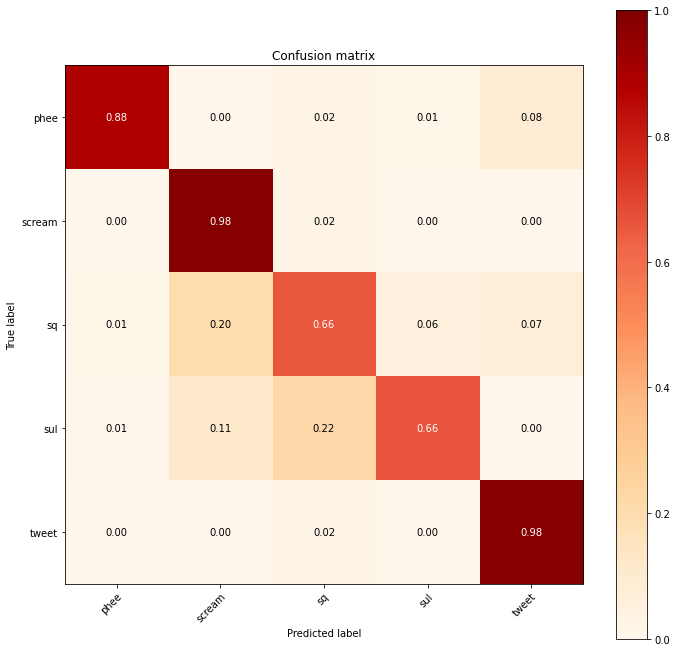

In [86]:
# Confusion matrix on the train data
cm = confusion_matrix(y_train, y_train_predicted)
fig = plot_confusion_matrix(cm, all_classes_str, 
                            figsize = (10, 10), cmap = plt.cm.OrRd, normalize = True, clim = (0, 1))
fig.savefig(path_to_models + dataset_name + '/confusion_matrix_train.png')

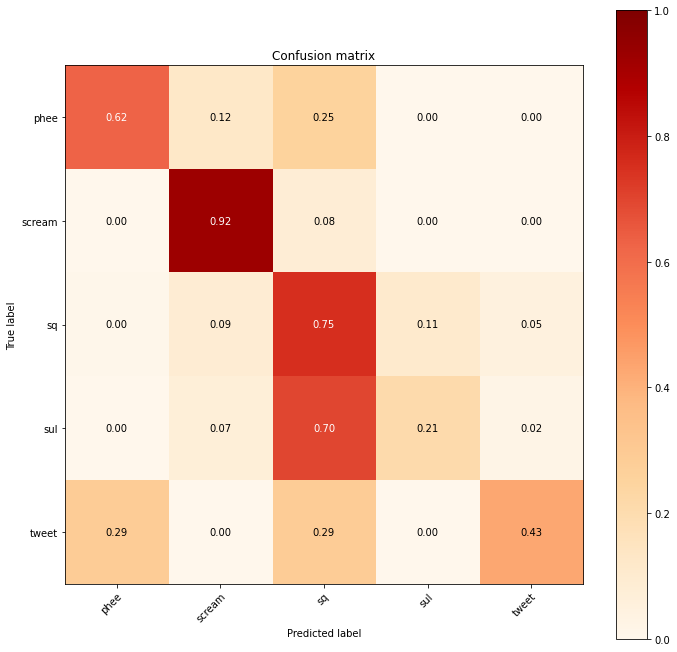

In [87]:
# Confusion matrix on the test data
cm = confusion_matrix(y_test, y_test_predicted)
fig = plot_confusion_matrix(cm, all_classes_str, 
                            figsize = (10, 10), cmap = plt.cm.OrRd, normalize = True, clim = (0, 1))
fig.savefig(path_to_models + dataset_name + '/confusion_matrix_test.png')